<img src="https://www.luxonis.com/logo.svg" width="400">

# Training a Semantic Segmentation Model

## 🌟 Overview
In this tutorial, we'll go through the process of training a custom semantic segmentation model. We'll first create a dataset by merging an existing dataset with a synthetically generated one, set up the training configuration, and then use it to train our own NN model. We'll also validate the performance of our model, export it, make it ready for deployment on a Luxonis device, and finally test it on a device.

## 📜 Table of Contents
- [🛠️ Installation](#installation)
- [🗃️ Data Preparation](#data-preparation)
    - [📚 Parsing the Data](#parsing-the-data)
    - [🧐 Generating Synthetic Dataset](#generating-synthetic-dataset)
    - [💾 LuxonisDataset](#luxonisdataset)
- [🏋️‍♂️ Training](#️️training)
    - [⚙️ Configuration](#️configuration)
    - [🦾 Train](#train)
- [✍ Test](#test)
    - [🧠 Infer](#infer)
- [🗂️ Export and Archive](#export-and-archive)
- [🤖 Deploy](#deploy)
- [📷 DepthAI Script](#depthai-script)


<a name ="️installation"></a>

## 🛠️ Installation

The main focus of this tutorial is using [`LuxonisTrain`](https://github.com/luxonis/luxonis-train) together with [`DataDreamer`](https://github.com/luxonis/datadreamer). [`LuxonisTrain`](https://github.com/luxonis/luxonis-train) is a user-friendly tool designed to streamline the training of deep learning models, especially for edge devices. [`DataDreamer`](https://github.com/luxonis/datadreamer) is an advanced toolkit for generating synthetic datasets and annotating images using the latest foundational models. We'll also use [`LuxonisML`](https://github.com/luxonis/luxonis-ml) since it provides us with a collection of utility functionality and an easy way of creating and managing computer vision datasets called `LuxonisDataset`. And lastly, we'll use the [`datasets`](https://huggingface.co/docs/datasets/en/index) package to download our data.

In [ ]:
%pip install -q opencv-python datasets>=3.1.0 luxonis-train==0.3.0 luxonis-ml==0.6.1 datadreamer@git+https://github.com/luxonis/datadreamer.git@main -U

<a name ="data-preparation"></a>

## 🗃️ Data Preparation

First, we need to download and prepare our dataset. For this example, we'll use a publicly available dataset from HuggingFace called [`Pothole Segmentation`](https://huggingface.co/datasets/keremberke/pothole-segmentation). Our task is to train a model that can detect and segment potholes. 

To download the dataset from HuggingFace, we'll run this:

In [1]:
from datasets import load_dataset

ds = load_dataset("keremberke/pothole-segmentation", name="full")
example = ds['train'][0]

print(example, type(ds))

{'image_id': 2, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7BFB22958CD0>, 'width': 640, 'height': 640, 'objects': {'id': [2], 'area': [19749], 'bbox': [[224.0, 282.0, 186.70799255371094, 105.77799987792969]], 'segmentation': [[[223.79600524902344, 320.15301513671875, 239.21200561523438, 307.4599914550781, 251.19500732421875, 292.6510009765625, 281.5060119628906, 294.7669982910156, 333.6700134277344, 296.8819885253906, 347.76800537109375, 302.52398681640625, 365.3900146484375, 298.99798583984375, 375.2590026855469, 296.177001953125, 381.6029968261719, 287.0090026855469, 390.06201171875, 282.072998046875, 401.34100341796875, 284.1889953613281, 397.1109924316406, 295.47198486328125, 390.06201171875, 293.3559875488281, 385.8330078125, 332.1409912109375, 383.7179870605469, 336.37200927734375, 396.406005859375, 342.718994140625, 410.5039978027344, 347.6549987792969, 397.8160095214844, 355.4119873046875, 387.9469909667969, 358.2330017089844, 374.5539855957031

<a name ="parsing-the-data"></a>

### 📚 Parsing the Data

Before continuing, it is always good practice to visualize the data and inspect what we have. We'll begin by visualizing an example.

In [2]:
labels = ["pothole"]

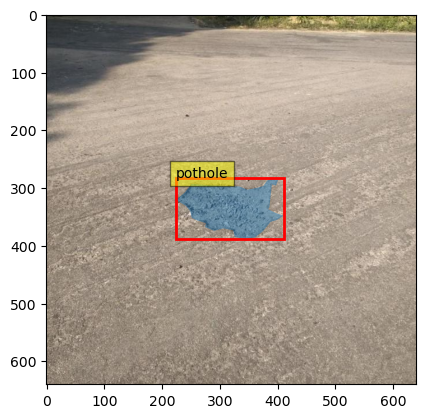

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img = example["image"]
fig, ax = plt.subplots(1)
ax.imshow(img)
for bbox, seg_mask, label in zip(example["objects"]["bbox"], example["objects"]["segmentation"], example["objects"]["category"]):
    x_points = seg_mask[0][::2]
    y_points = seg_mask[0][1::2]
    ax.fill(x_points, y_points, label, alpha=0.5)
    x1 = int(round(bbox[0]))
    y1 = int(round(bbox[1]))
    
    rect = patches.Rectangle(
        (x1, y1),
        int(round(bbox[2])),
        int(round(bbox[3])),
        linewidth=2,
        edgecolor="r",
        facecolor="none",
    )
    ax.add_patch(rect)
    plt.text(
        x1,
        y1,
        f"{labels[label]}",
        bbox=dict(facecolor="yellow", alpha=0.5),
    )

plt.show()

Now, let's see how many examples do we have in the dataset.

In [4]:
print(f"# of examples in train set: {len(ds['train'])}")
print(f"# of examples in validation set: {len(ds['validation'])}")
print(f"# of examples in test set: {len(ds['test'])}")

# of examples in train set: 80
# of examples in validation set: 5
# of examples in test set: 5


We can see that we have only `90` samples in total, which is very few. We will generate additional samples using the [`DataDreamer`](https://github.com/luxonis/datadreamer) toolkit to generate additional examples.

<a name ="generating-synthetic-dataset"></a>

### 🧐 Generating Synthetic Dataset

To generate additional samples, let's use [`DataDreamer`](https://github.com/luxonis/datadreamer).

To discover all available DataDreamer arguments, please refer to [here](https://github.com/luxonis/datadreamer?tab=readme-ov-file#-main-parameters). Generating `80` images takes about `~8.5` minutes, and annotating them takes about `~4.5` minutes (measured on a device with Nvidia L4 GPU with 24 GB memory). Please change the arguments according to your device (increase/decrease `batch_size_annotation`, switch device to `cpu`, bigger/smaller `annotator_size` and `synonym_generator` from `llm` to `wordnet`).

If you use Google Colaboratory, please use the second command to generate the synthetic dataset.

In [ ]:
# If you are using a stronger GPU (such as Nvidia L4 GPU), you can use the following command:
!datadreamer --save_dir synthetic_pothole_dataset \
            --class_names pothole \
            --prompts_number 80 \
            --prompt_generator simple \
            --prompt_prefix "Weathered, rural asphalt road. " \
            --conf_threshold 0.6 \
            --synonym_generator llm \
            --num_objects_range 1 1 \
            --disable_lm_filter \
            --image_generator sdxl-lightning \
            --image_annotator owlv2-slimsam \
            --task instance-segmentation \
            --use_image_tester \
            --image_tester_patience 3 \
            --use_tta \
            --raw_mask_format polyline \
            --vis_anns \
            --seed 123 \
            --annotation_iou_threshold 0.45 \
            --annotator_size large \
            --batch_size_annotation 2
# If you are using a weaker GPU or Google Colab, you can use the following command:
# !datadreamer --save_dir synthetic_pothole_dataset4 \
#             --class_names pothole \
#             --prompts_number 80 \
#             --prompt_generator simple \
#             --prompt_prefix "Weathered, rural asphalt road. " \
#             --conf_threshold 0.6 \
#             --synonym_generator wordnet \
#             --num_objects_range 1 1 \
#             --disable_lm_filter \
#             --image_generator sdxl-turbo \
#             --image_annotator owlv2-slimsam \
#             --task instance-segmentation \
#             --use_tta \
#             --raw_mask_format polyline \
#             --seed 123 \
#             --vis_anns \
#             --annotation_iou_threshold 0.45 \
#             --annotator_size large \
#             --batch_size_annotation 1

Let's visualize one generated example.

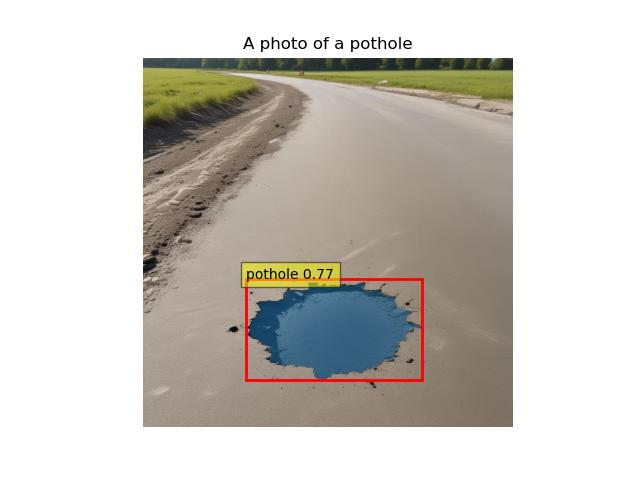

In [6]:
from IPython.display import Image
Image(filename='synthetic_pothole_dataset/bboxes_visualization/bbox_0000002.jpg')

<a name ="luxonisdataset"></a>

### 💾 LuxonisDataset

Now that we have our data, we can create a `LuxonisDataset`.  We will start by creating a dataset instance called `pothole_dataset`.

In [ ]:
from luxonis_ml.data import LuxonisDataset

dataset = LuxonisDataset(dataset_name="pothole_dataset", delete_existing=True) # if dataset with this name already exists then we delete the old instance

To add data to `LuxonisDataset`, you must create a generator function that yields annotations in the correct format. For semantic segmentation, the annotations should be in `[(x_0, y_1), (x_1, y_1), ...]` format with all the values normalized between `[0,1]`. Since we have two datasets, one synthetically generated and one already downloaded from HuggingFace. We will need to write two generators for each of the datasets.

Let's now create functions called `process_dataset` and `process_synthetic_dir`, which will get a path to the directory and return a generator function of type `DatasetIterator` and a list of paths of added images for the corresponding dataset.

In [ ]:
from luxonis_ml.data import DatasetIterator
from PIL import Image
from pathlib import Path
import numpy as np
import json
import os
import datasets


def process_synthetic_dir(dir_path: str) -> tuple[DatasetIterator, list[str]]:
    with open(os.path.join(dir_path, "annotations.json")) as f:
        data = json.load(f)
    
    class_names = data["class_names"]
    image_paths = list(data.keys())
    image_paths.remove("class_names")

    filter_image_paths = list(filter(lambda x: len(data[x]["labels"]) >= 1, image_paths))
    full_image_paths = list(map(lambda x: os.path.join(dir_path, x), filter_image_paths))
    
    def generator():
        for image_path in filter_image_paths:
            image_full_path = os.path.join(dir_path, image_path)
            width, height = Image.open(image_full_path).size
            labels = data[image_path]["labels"]
            # polyline format
            masks = data[image_path]["masks"]
            for mask, label in zip(masks, labels):
                poly = [
                    (point[0] / width, point[1] / height) for point in mask
                ]
                yield {
                    "file": image_full_path,
                    "annotation": {
                        "class": "pothole",
                        "segmentation": {
                            "height": height,
                            "width": width,
                            "points": poly,
                        }
                    }
                }
    
    return generator(), full_image_paths 


def process_dataset(ds: datasets.dataset_dict.DatasetDict, split: str) -> tuple[DatasetIterator, list[str]]:
    output_dir = "pothole_hf_dataset"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = []
    segments = []
    resolutions = []
    for sample in ds[split]:
        if len(sample["objects"]["segmentation"]) == 0:
            continue
        img_path = os.path.join(output_dir, f"img_{split}_{sample['image_id']}.jpg")
        sample["image"].save(img_path)
        images.append(img_path)
        segments.append(sample["objects"]["segmentation"])
        resolutions.append((sample["width"], sample["height"]))
    
    def generator() -> DatasetIterator:
        for i, (res, img_name) in enumerate(zip(resolutions, images)):
            w, h = res
            for mask in segments[i]:
                poly_arr = np.array(mask).reshape(-1, 2)
                poly = [
                    (poly_arr[j, 0]/w, poly_arr[j, 1]/h)
                    for j in range(len(poly_arr))
                ]
                yield {
                    "file": img_name,
                    "annotation": {
                        "class": "pothole",
                        "segmentation": {
                            "height": h,
                            "width": w,
                            "points": poly,
                        }
                    }
                }
    
    return generator(), images

We can now use these functions to process both datasets and add them to our `LuxonisDataset` instance. 

In [ ]:
synthetic_gen, synthetic_images = process_synthetic_dir(dir_path="synthetic_pothole_dataset")

train_gen, train_images = process_dataset(ds=ds, split="train")
val_gen, val_images = process_dataset(ds=ds, split="validation")
test_gen, test_images = process_dataset(ds=ds, split="test")

# Add data to the dataset
dataset = dataset.add(synthetic_gen)
dataset = dataset.add(train_gen)
dataset = dataset.add(val_gen)
dataset = dataset.add(test_gen)

The last step is to split the data into `train`, `value`, and `test` subsets. We'll use 80% of the generated data to expand the training set and 10% for both a validation and a test set.

In [10]:
import random
from random import shuffle
random.seed(123)

shuffle(synthetic_images) # shuffle the images
train_val_split_idx = int(len(synthetic_images) * 0.8)
val_test_split_idx = train_val_split_idx + int((len(synthetic_images) - train_val_split_idx)/2)

synthetic_train_images = synthetic_images[:train_val_split_idx]
synthetic_val_images = synthetic_images[train_val_split_idx:val_test_split_idx]
synthetic_test_images = synthetic_images[val_test_split_idx:]

dataset.make_splits(
    splits={
        "train": train_images + synthetic_train_images,
        "val": val_images + synthetic_val_images,
        "test": test_images + synthetic_test_images
    }
)

To verify that the data is correctly loaded and split into subsets, we can check the dataset's information and visualizations of the annotations.

In [11]:
!luxonis_ml data info pothole_dataset

WARNING  /opt/conda/lib/python3.11/site-packages/albumentations/__ ]8;id=720282;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=683321;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#86\86]8;;\
         init__.py:24: UserWarning: A new version of                            
         Albumentations is available: 2.0.5 (you have 1.4.22).                  
         Upgrade using: pip install -U albumentations. To disable               
         automatic update checks, set the environment variable                  
         NO_ALBUMENTATIONS_UPDATE to 1.                                         
           check_for_updates()                                                  
                                                                                
╭────────── Dataset Info ──────────╮
│ Name: pothole_dataset            │
│ Version: 2.0.0                   │
│                                  │
│ ╭─ Sp

In [61]:
!luxonis_ml data inspect pothole_dataset # NOTE: If you are on Google Colab this command will not work

<a name ="️️training"></a>

## 🏋️‍♂️ Training

<a name ="️configuration"></a>

### ⚙️ Configuration

We have prepared the dataset and are almost ready for the actual training. The last step is just to set up our training configuration file. The whole training process in `LuxonisTrain` doesn't require any coding. We advise you to take one of the base configuration files from [here](https://github.com/luxonis/luxonis-train/tree/main/configs) depending on the task, and then edit it to fit your needs.

In our case, since we are training a semantic segmentation model, we'll take a [`segmentation_light_model.yaml`](https://github.com/luxonis/luxonis-train/blob/main/configs/segmentation_light_model.yaml) config as a starting point, which downloads pre-trained COCO weights, making it ideal for fine-tuning. There are many parameters that we can change, and we advise you to go through the [`documentation`](https://github.com/luxonis/luxonis-train/blob/main/configs/README.md) to find all of them. In this tutorial, we'll only go through some basic ones to get you started on your journey.

#### Model
In this section, you can either choose one of the predefined architectures (all of them listed [here](https://github.com/luxonis/luxonis-train/tree/main/luxonis_train/config/predefined_models)) or create a completely custom neural network by connecting different nodes, losses, metrics, and visualizers. We'll go with the predefined `SegmentationModel`.

#### Loader
This section of the config refers to the data loading. You can either set up your custom `Loader` or use the default one with the `LuxonisDataset`. In our case, we'll go with the second option; all we need to do is set `dataset_name` to `pothole_dataset`.

#### Trainer
In this section, we can set up everything connected to the actual training. You can change preprocessing, batch size, epochs, add callbacks, augmentations, change optimizers, schedulers, and more. Please refer to the [complete documentation](https://github.com/luxonis/luxonis-train/tree/main/configs). 

#### Augmentations
In this tutorial, we'll leave most things as they are; the only change will be adding some augmentations. `Luxonis-train` uses [`Albumentations`](https://albumentations.ai/) for augmentations by adding custom ones like `Mosaic4` and `MixUp`. You can use [this demo](https://demo.albumentations.ai/) to experiment and find those that work for your specific training run. In this training run, we'll add `Affine`, `HorizontalFlip` and `ColorJitter` augmentations, but feel free to edit this.

#### Callbacks 
Callbacks are very helpful when merging more functionalities into a single training run. For example, we want to train the model, evaluate it on a test subset, export it, and create an archive. These steps can be defined through the config and done by a single call. We won't use them in this tutorial for a more straightforward explanation but feel free to set them up independently. You can check out all the available callbacks [here](https://github.com/luxonis/luxonis-train/tree/main/luxonis_train/callbacks).

Below is a starting point for our config. As mentioned before, we already made some changes to it, so it works with this tutorial (model name and dataset name change, addition of augmentations), but feel free to edit it further and make it your own. When you are done editing, you can execute the cell, and the file will be written and ready to use.

**Note**: In case you don't have enough computing power on your machine, you can either use [Google Colab](https://colab.research.google.com/) (with GPU enabled), or you can try tweaking the training hyperparameters (such as lowering number of epochs or batch size). However, please be aware that bad parametrization can result in worse performance.

In [12]:
%%writefile pothole_segmentation_config.yaml
model:
  name: pothole_segmentation_model
  predefined_model:
    name: SegmentationModel
    params:
      variant: light

loader:
  params:
    dataset_name: pothole_dataset

trainer:
  preprocessing:
    train_image_size: [512, 512]
    keep_aspect_ratio: true
    normalize:
      active: true

    augmentations:
      - name: Affine
        params:
          scale: [0.7, 1.5]
          rotate: 20
          shear: 5
          p: 0.3
      - name: HorizontalFlip
        params:
          p: 0.3
      - name: ColorJitter
        params:
          brightness: [0.8, 1.2]
          contrast: [0.8, 1.2]
          saturation: [0.8, 1.2]
          hue: 0
          p: 0.2

  batch_size: 8
  epochs: &epochs 20
  num_workers: 4
  validation_interval: 10
  num_log_images: 8

  optimizer:
    name: SGD
    params:
      lr: 0.0002
      momentum: 0.937
      weight_decay: 0.0005
      nesterov: true

  scheduler:
    name: CosineAnnealingLR
    params:
      T_max: *epochs
      eta_min: 0.00001

Writing pothole_segmentation_config.yaml


<a name ="train"></a>

### 🦾 Train

To start the training, we need to initialize the `LuxonisModel`, pass it the path to the configuration file, and call the `train()` method on it.

**Note**: LuxonisTrain also supports all these commands through usage of its CLI ([docs here](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#-cli)), no code required. We won't use them for tutorial purposes but feel free to use them when you do it yourself.

In [ ]:
from luxonis_train import LuxonisModel

config_path = "pothole_segmentation_config.yaml"

luxonis_model = LuxonisModel(config_path)
luxonis_model.train()

`LuxonisTrain` has also already implemented automatic tracking of training runs. By default, `Tensorboard` is used, and to look at the losses, metrics, and visualizations during training, we can inspect the logs. If you check the `output` folder, you'll see that every run creates a new directory, and each run also has its training logs in the `./output/tensorboard_logs` where the name of the folder matches the run's name. To make all the subsequent commands work automatically, please set the name of your run below.

In [ ]:
RUN_NAME = "<YOUR_RUN_NAME>"

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output/tensorboard_logs/{RUN_NAME}/ # TODO: Change the name of the training run

<a name ="test"></a>

## ✍ Test

Now, we have a trained model that performs well on the validation set. The next step is to check its performance on the testing set, a collection of images we've kept hidden from the model. It should only be used to evaluate whether the model is good objectively. Since this is a semantic segmentation task, we use the Jaccard Index and F1 Score metric to check the model performance quantitatively.

If you check out the run directory, you'll see two folders inside: `best_val_metric` and `min_val_loss`. Both have checkpoint files generated during training based on best validation metric performance and minimal validation loss. For evaluation, we'll want to use one of these checkpoints; we recommend that you use one that has the lowest validation loss.

In [14]:
weights = luxonis_model.get_min_loss_checkpoint_path() # gets checkpoint where validation loss was the lowest
# weights = luxonis_model.get_best_metric_checkpoint_path() # gets checkpoint where validation metric was the highest

metrics = luxonis_model.test(view="test", weights=weights)

WARNING  /opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py:1022: You  ]8;id=560131;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=142025;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#86\86]8;;\
         are using `torch.load` with `weights_only=False` (the current default value), which uses the              
         default pickle module implicitly. It is possible to construct malicious pickle data which                 
         will execute arbitrary code during unpickling (See                                                        
         https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details).              
         In a future release, the default value for `weights_only` will be flipped to `True`. This                 
         limits the functions that could be executed during unpickling. Arbitrary objects will no                  
         longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the                
         user via `torch.serialization.add_safe_globals`. We recommend you start setting                           
         `weights_only=True` for any use case where you don't have full control of the loaded file.                
         Please open an issue on GitHub for any issues related to this experimental feature.                       
                                                                                                                   

INFO     Loaded checkpoint from                                                           ]8;id=417706;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=814695;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#1049\1049]8;;\
         /home/jovyan/update-tutorials/output/22-rose-lynx/min_val_loss/pothole_segmentat                          
         ion_model_loss=0.7576_19.ckpt.                                                                            

INFO     The following callbacks returned in `LightningModule.configure_callbacks` will override    ]8;id=868457;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=606018;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\
         existing callbacks passed to Trainer: ModelCheckpoint, RichModelSummary                                   

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO     Computing metrics on test subset ...                                              ]8;id=958920;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=235038;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#860\860]8;;\

INFO     Metrics computed.                                                                 ]8;id=639370;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=665617;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#862\862]8;;\

INFO     Test loss: 0.7768                                                                ]8;id=630401;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=638748;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#1104\1104]8;;\

────────────────────────────────────────────────────── Test ───────────────────────────────────────────────────────

Loss: 0.7767511606216431

Metrics:

 -DDRNetSegmentationHead  
┏━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Name         ┃ Value   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ JaccardIndex │ 0.63340 │
│ F1Score      │ 0.77556 │
└──────────────┴─────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Test main metric (-DDRNetSegmentationHead/JaccardIndex): 0.6334                  ]8;id=128257;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=724848;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#1115\1115]8;;\

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                       test/loss                        │                   0.7767511606216431                   │
│ test/loss/-DDRNetSegmentationHead/OHEMBCEWithLogitsLo… │                   0.7767511606216431                   │
│      test/metric/-DDRNetSegmentationHead/F1Score       │                   0.7755594253540039                   │
│    test/metric/-DDRNetSegmentationHead/JaccardIndex    │                   0.6333990097045898                   │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

<a name ="infer"></a>

### 🧠 Infer

Usually, we also want to visualize the prediction of the trained model on test images to ensure it does what it is supposed to do. This is called inference, and we can perform it either on one of the views (e.g., test) or a random image, directory of images, or whole video (for more details, refer to the [docs](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#inference)). In our case, we'll infer the model on test images.

In [ ]:
# NOTE: If you are using Google Colab use this and images will be saved to "infer_results_pothole_model" directory
luxonis_model.infer(weights=weights, save_dir="infer_results_pothole_model", view="test")

# NOTE: If you are not using Google Colab use this and images will be displayed
# luxonis_model.infer(
#     weights=weights,
#     view="test"
# ) 

Now, let's visualize one of the predictions.

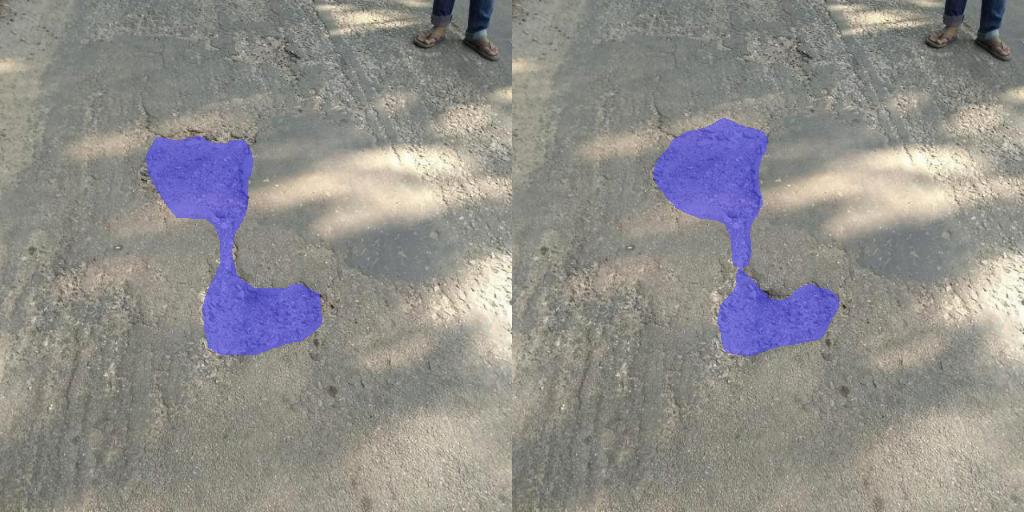

In [22]:
from IPython.display import Image
Image(filename='infer_results_pothole_model/-DDRNetSegmentationHead_SegmentationVisualizer_2.png')

On the left above, we can see the annotation; on the right, we can see the prediction.

<a name ="export-and-archive"></a>

## 🗂️ Export and Archive

Once the model is trained and tested, we want to prepare it for deployment on the device. This preparation consists of 2 steps. First, we want to export the model trained with PyTorch to a more general format called [`Open Neural Network Exchange (ONNX)`](https://onnx.ai/). Then, we want to package this exported model with all the metadata containing information about the inputs, outputs, and training configuration used. This is called archiving. These steps can be done quickly with just one command in `LuxonisTrain`.

In [ ]:
archieve_path = luxonis_model.archive(weights=weights)
print("Model archieved to:", archieve_path)

Notice that two new folders were created in our run directory. One is called `export` and has an ONNX model while the other is called `archive` which has `.tar.xz` file. The tar file is a compressed file that holds the aforementioned ONNX model with all the model metadata.

<a name ="deploy"></a>

## 🤖 Deploy

Now that we have successfully exported and archived the model, we aim to deploy it to the Luxonis device. The model's specific format depends on the Luxonis device series you have. We will show you how to use our [`ModelConverter`](https://github.com/luxonis/modelconverter) to convert the model as simply as possible. 

We'll start by installing the `ModelConverter`.

In [ ]:
%pip install -q modelconv@git+https://github.com/luxonis/modelconverter.git@main -U

We will use `ModelConverter`'s Python API, which utilizes our [`HubAI`](https://hub.luxonis.com) to convert the model in the background. To start with the conversion, you need to create an account on the `HubAI` platform and obtain the API key for your team.

To log in to HubAI, use the following command:

In [1]:
!modelconverter hub login

WARNING  /Users/jancuhel/miniconda3/envs/luxonis-tutorials/lib/pyt ]8;id=7299;file:///Users/jancuhel/miniconda3/envs/luxonis-tutorials/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=97379;file:///Users/jancuhel/miniconda3/envs/luxonis-tutorials/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#86\86]8;;\
         hon3.11/site-packages/albumentations/__init__.py:24:                   
         available: 2.0.5 (you have 1.4.22). Upgrade using: pip                 
         install -U albumentations. To disable automatic update                 
         checks, set the environment variable                                   
         NO_ALBUMENTATIONS_UPDATE to 1.                                         
           check_for_updates()                                                  
                                                                                
User already logged in. Use `modelconverter hub --relogin` to relogin.


To convert the model, we can use either CLI or Python API. We'll use the latter. For more information, please look [here](https://github.com/luxonis/modelconverter?tab=readme-ov-file#online-usage).

The call below will create a new model card inside your team on `HubAI` with the model file and details uploaded. It will further convert the model on the cloud to the selected target platform (e.g. [`RVC2`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc2/), [`RVC4`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc4/)) and download the converted model to your device. Choosing the target is as simple as setting a `target` argument in the `convert` function.

Besides this, there are some platform-specific parameters. To check them out, please visit our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/conversion/rvc-conversion/offline/modelconverter/#ModelConverter-Parameters-Platform-Specific).

In [2]:
# NN_ARCHIVE_PATH = "<YOUR_MODEL_ARCHIVE_PATH>"
NN_ARCHIVE_PATH = "pothole_segmentation_model.onnx.tar.xz"

In [3]:
from modelconverter import convert

converted_model = convert(
    "rvc2",
    path=NN_ARCHIVE_PATH,
    name="Pothole Segmentation Model",
    description_short="Trained semantic segmentation model on the pothole segmentation dataset.",
    tasks=["SEGMENTATION"],
    license_type="MIT",
    is_public=False
)

WARNING  /Users/jancuhel/miniconda3/envs/luxonis-tutorials/lib/python3.11/site-packages/albumentation ]8;id=119128;file:///Users/jancuhel/miniconda3/envs/luxonis-tutorials/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=67968;file:///Users/jancuhel/miniconda3/envs/luxonis-tutorials/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#86\86]8;;\
         s/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have              
         1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks,                
         set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.                                               
           check_for_updates()                                                                                     
                                                                                                                   

Model variant 'Pothole Segmentation Model 512x512' created with ID '52483e49-36b6-4b77-b84f-23906d5c99ec'

Model instance 'Pothole Segmentation Model 512x512 base instance' created with ID 
'9a56ceb4-d94f-42fb-b7ca-50c7ac7ed3a0'

File 'pothole_segmentation_model.onnx.tar.xz' uploaded to model instance '9a56ceb4-d94f-42fb-b7ca-50c7ac7ed3a0'

Model instance 'Pothole Segmentation Model 512x512 exported to rvc2' created for rvc2 export with ID 
'f05c56d3-473d-4b1f-adc6-fea38a406f21'

Output()

Donwloaded 'pothole-segmentation-model-512x512-exported-to-rvc2/pothole_segmentation_model.rvc2.tar.xz'

We have successfully converted our trained model for an RVC2 device, so let's test it! Please copy the path to the downloaded archive with the converted model from the output log of the last code cell; we will use it in the next section.

In [4]:
MODEL_PATH = "pothole-segmentation-model-512x512-exported-to-rvc2/pothole_segmentation_model.rvc2.tar.xz"

To check out other possible ways to convert your model for our devices, please refer to our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/conversion/rvc-conversion/).

<a name ="depthai-script"></a>

## 📷 DepthAI Script

To test our model on one of our cameras, we first need to install [`DepthAI`](https://rvc4.docs.luxonis.com/software/) in version 3 and [`DepthAI Nodes`](https://rvc4.docs.luxonis.com/software/ai-inference/depthai-nodes/). Moreover, the script we'll write must run locally and require a Luxonis device connected to your machine.

In [ ]:
%pip install --extra-index-url https://artifacts.luxonis.com/artifactory/luxonis-python-release-local/ depthai==3.0.0a14
%pip install -q depthai-nodes==0.2.0

Looking in indexes: https://pypi.org/simple, https://artifacts.luxonis.com/artifactory/luxonis-python-release-local/
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Here is the script to run the model on the DepthAI device:

In [ ]:
import cv2
import depthai as dai
from depthai_nodes import SegmentationMask
from depthai_nodes.node import ParsingNeuralNetwork
import numpy as np
from typing import List, Tuple



def visualize_segmentation(frame: np.ndarray, message: SegmentationMask, colors: List[Tuple[int, int, int]] = [(0, 255, 0)]) -> bool:
    """
    Visualize the segmentation mask on the frame
    :param frame: The frame to visualize the segmentation mask on
    :param message: The segmentation mask message
    :return: True if the user pressed "q", False otherwise
    """
    mask = message.mask
    mask = mask.reshape(mask.shape[0], mask.shape[1])
    frame = cv2.resize(frame, (mask.shape[1], mask.shape[0]))

    colormap = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_id, color in enumerate(colors):
        m = mask == class_id
        colormap[m] = color

    alpha = 0.5
    overlay = cv2.addWeighted(colormap, alpha, frame, 1 - alpha, 0)

    cv2.imshow("Segmentation", overlay)

    if cv2.waitKey(1) == ord("q"):
        cv2.destroyAllWindows()
        return True
    
    return False


device = dai.Device()
platform = device.getPlatform()
img_frame_type = dai.ImgFrame.Type.BGR888i if platform.name == "RVC4" else dai.ImgFrame.Type.BGR888p

with dai.Pipeline(device) as pipeline:
    cam = pipeline.create(dai.node.Camera).build()
    nn_archive = dai.NNArchive(MODEL_PATH)
    # Create the neural network node
    nn_with_parser = pipeline.create(ParsingNeuralNetwork).build(
        cam.requestOutput((512, 512), type=img_frame_type, fps=30), 
        nn_archive
    )
    # Create output queues
    parser_output_queue = nn_with_parser.out.createOutputQueue()
    frame_queue = nn_with_parser.passthrough.createOutputQueue()

    # Start pipeline
    pipeline.start()

    while pipeline.isRunning():
        # Get the frame
        frame: dai.ImgFrame = frame_queue.get().getCvFrame()
        # Get the parsed message containing the segmentation mask
        parser_msg: dai.ImgFrame = parser_output_queue.get()
        if visualize_segmentation(frame, parser_msg):
            pipeline.stop()
            break

Yay! 🎉🎉🎉 Huge congratulations, you have successfully finished this tutorial in which you deployed a pothole segmentation model trained using `luxonis-train` on a merged dataset of real and synthetically generated images using `DataDreamer` to our camera!